# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [3]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

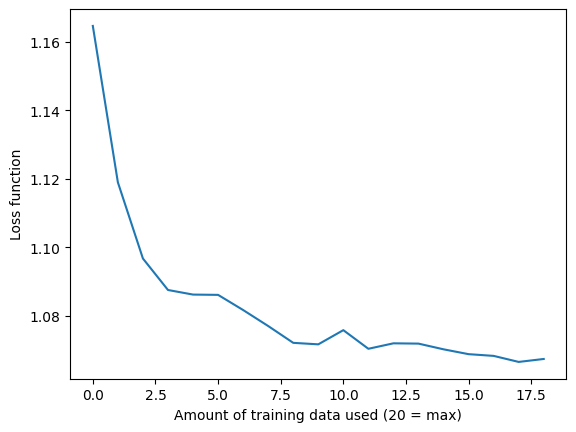

In [4]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [5]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

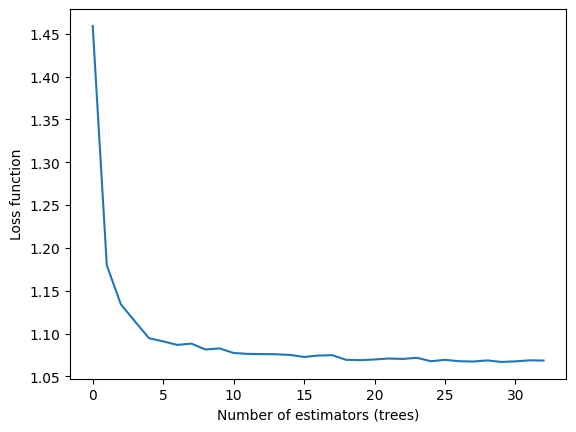

In [6]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_auc_score)
from sklearn.preprocessing import StandardScaler
data = pd.read_csv("diabetes.csv")  
data['Age_Group'] = pd.cut(data['Age'],
                          bins=[0, 30, 45, 60, 100],
                          labels=['Young', 'Adult', 'Middle-aged', 'Senior'])
# One-hot encoding
data = pd.get_dummies(data, columns=['Age_Group'], drop_first=True)

#Features and target
X = data.drop('Diabetes_012', axis=1)
y = data['Diabetes_012']

# Scale numerical features
scaler = StandardScaler()
num_cols = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth']  \
X[num_cols] = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4, stratify=y)

rf = RandomForestClassifier(random_state=4)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred))

# HYPERPARAMETER TUNING
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', {0:1, 1:2, 2:3}]
}

rf_tuned = RandomizedSearchCV(
    RandomForestClassifier(random_state=4),
    param_distributions=param_dist,
    n_iter=4,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=4
)
rf_tuned.fit(X_train, y_train)
print(f"Best Parameters: {rf_tuned.best_params_}")
print(f"Best CV Accuracy: {rf_tuned.best_score_:.3f}")

# FINAL EVALUATION
best_rf = rf_tuned.best_estimator_

# Cross-validation
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy')
print(f"\nCross-validated Accuracy: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

# Test set evaluation
y_pred_tuned = best_rf.predict(X_test)
print("\nTUNED MODEL REPORT:")
print(classification_report(y_test, y_pred_tuned))

# Confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# FEATURE IMPORTANCE
print("\n Analyzing feature importance...")

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Top Predictive Features")
plt.bar(range(10), importances[indices][:10], align="center")
plt.xticks(range(10), X.columns[indices][:10], rotation=45)
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# ROC AUC (one-vs-rest for multiclass)
y_probs = best_rf.predict_proba(X_test)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_probs, multi_class='ovr'):.3f}")

SyntaxError: invalid syntax (3119648157.py, line 24)

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

/tmp/ipykernel_619/4258212393.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_data = diabetes.groupby('Age_Group').agg({


ValueError: Axis limits cannot be NaN or Inf

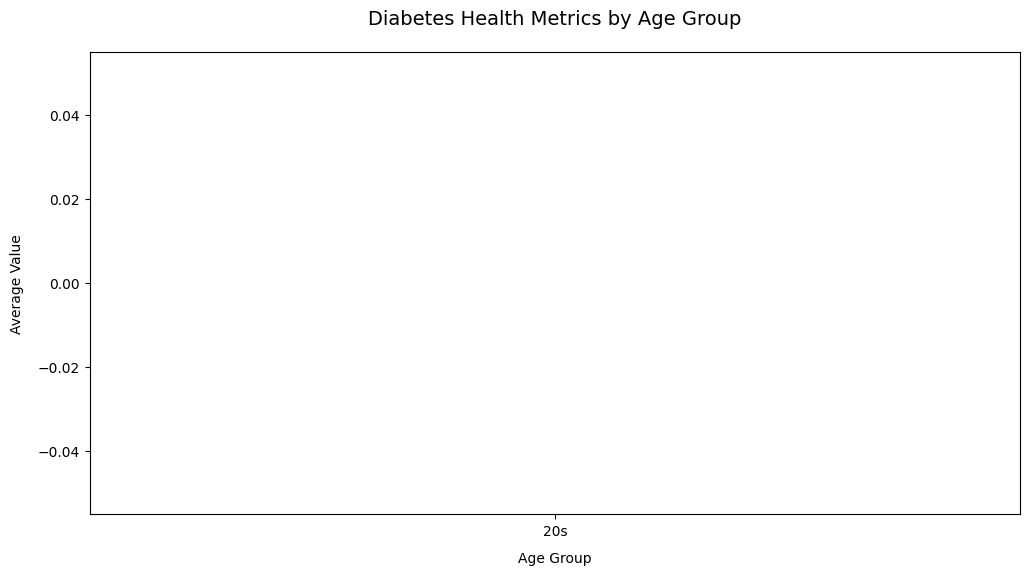

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load diabetes data
diabetes = pd.read_csv("diabetes.csv")

# 1. Prepare data for temporal analysis (if you have year/time data)
# If no time data, we'll use age groups instead
diabetes['Age_Group'] = pd.cut(diabetes['Age'], 
                              bins=[20, 30, 40, 50, 60, 70, 80],
                              labels=['20s', '30s', '40s', '50s', '60s', '70+'])

# Calculate average metrics by age group
avg_data = diabetes.groupby('Age_Group').agg({
    'BMI': 'mean',
    'GenHlth': 'mean',  # General Health (1-5 scale)
    'HighBP': 'mean',   # % with high blood pressure
    'Diabetes_012': 'mean'  # % with diabetes
}).reset_index()

# 2. Create the line chart
plt.figure(figsize=(12, 6))

# Plot lines for each metric
metrics = ['BMI', 'HighBP', 'Diabetes_012']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for metric, color in zip(metrics, colors):
    plt.plot(avg_data['Age_Group'], avg_data[metric], 
             marker='o', label=metric, color=color, linewidth=2.5)

# Customize the chart
plt.title('Diabetes Health Metrics by Age Group', pad=20, fontsize=14)
plt.xlabel('Age Group', labelpad=10)
plt.ylabel('Average Value', labelpad=10)
plt.ylim(0, 1.5*avg_data[metrics].max().max())  # Adjust scale

# Second y-axis for BMI (different scale)
ax2 = plt.gca().twinx()
ax2.plot(avg_data['Age_Group'], avg_data['BMI'], 
         marker='s', label='BMI', color='#9467bd', linestyle='--', linewidth=2)
ax2.set_ylabel('BMI', color='#9467bd')
ax2.tick_params(axis='y', colors='#9467bd')
ax2.set_ylim(0, 1.5*avg_data['BMI'].max())

# Combine legends
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.gca().legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()